In [1]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_groq import ChatGroq

In [2]:
llm = ChatGroq(model="llama3-70b-8192")
llm.invoke("hi")

AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.075148405, 'prompt_time': 0.000120199, 'queue_time': 0.151277617, 'total_time': 0.075268604}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'finish_reason': 'stop', 'logprobs': None}, id='run--b40b6b9a-8ef4-485a-bee3-a4aa47190519-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})

In [3]:
generation_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a twitter techie influencer assistant tasked with writing excellent twitter posts."
     "Generate the best twitter post possible for the user's request."
     "If the user provides critique, respond with a revised version of your previous attempts."
     ),
     MessagesPlaceholder(variable_name="messages"),
])

In [4]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a viral twitter influencer grading a tweet. Generate critique and recommendations for the user's tweet."
            "Always provide detailed recommendations, including requests for length, virality, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

llm = ChatGroq(model="llama3-70b-8192")

In [5]:
generation_chain = generation_prompt | llm
reflection_chain = reflection_prompt | llm

In [6]:
from typing import List, Sequence
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.graph import END, MessageGraph



In [7]:
REFLECT = "reflect"
GENERATE = "generate"
graph = MessageGraph()

In [8]:
def generate_node(state):
    return generation_chain.invoke({
        "messages": state
    })


def reflect_node(messages):
    response = reflection_chain.invoke({
        "messages": messages
    })
    return [HumanMessage(content=response.content)]


graph.add_node(GENERATE, generate_node)
graph.add_node(REFLECT, reflect_node)
graph.set_entry_point(GENERATE)


In [9]:
def should_continue(state):
    if (len(state) > 6):
        return END 
    return REFLECT


graph.add_conditional_edges(GENERATE, should_continue)
graph.add_edge(REFLECT, GENERATE)

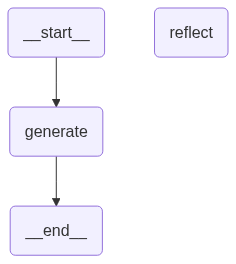

In [10]:
app = graph.compile()
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [11]:
response = app.invoke(HumanMessage(content="AI Agents taking over content creation"))
print(response)

[HumanMessage(content='AI Agents taking over content creation', additional_kwargs={}, response_metadata={}, id='61c5545e-24fc-4d4d-8f17-723ab908f6d4'), AIMessage(content="Here's a possible Twitter post:\n\nBREAKING: AI Agents are REVOLUTIONIZING Content Creation! From writing articles to generating art, AI is taking the creative reins! But what does this mean for human creators? Will AI augment our abilities or replace us altogether? Share your thoughts! #AIinContent #FutureOfWork\n\nPlease let me know if you'd like me to revise anything!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 63, 'total_tokens': 142, 'completion_time': 0.313271056, 'prompt_time': 0.001625596, 'queue_time': 0.15168516499999998, 'total_time': 0.314896652}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'finish_reason': 'stop', 'logprobs': None}, id='run--ba1abc06-635e-4372-a62e-d242fa303e80-0', usage_metadata={'input_tokens': 63, 'out